In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygam
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
import os
from matplotlib import rc
import math  

# IEEE Transactions Recommended fonts are:Times New Roman, Helvetica, Arial, Cambria, and Symbol "
plt.rcParams['font.family'] = "arial"

### Model Definition

In [2]:
class CFModel:
    def __init__(self, depth, data_file='../data/functest.in', k=3, lam=2, norm=10):
        '''
        depth - the depth of the continued fraction (note this is 1 indexed, so 1 is the smallest possible depth)
        data_file - a .in file containing the training data
        k - the number of new knots to place at each depth
        lam - the regularization parameter lambda
        '''
        self.depth = depth
        self.data_file = data_file
        self.norm=norm
        self.read_data()
        self.min_coeff = np.zeros((self.depth + 2, ))
        
        self.k = k
        self.lam = lam
        
        #self.X, self.X_test, self.y, self.y_test = train_test_split(self.X, self.y, test_size=0.2)
                        
        # self.knot_indices contains the indices of the samples at which the knots are placed. 
        self.knot_indices = []
        
    def read_data(self):
        '''
        Gets the X and y data from a .in file.
        
        The X and y data are stored in the attributes
        self.X and self.y.
        
        self.n is the number of samples, and self.m is the
        number of features
        '''
        with open(self.data_file, 'r') as f:
            n, m = f.readline().split('\t')
            self.n, self.m = int(n), int(m)
            self.X = np.zeros((self.n, self.m))
            self.y = np.zeros((self.n, ))
            for i, line in enumerate(f):
                points = [float(j) for j in line.split('\t')]
                self.y[i] = points[0]
                self.X[i] = points[1:]
                        
        self.y /= self.norm
                        
    def fit(self):
        '''
        Fits the model on self.X and self.y.
        '''
        self.models = []
        yfit = self.y
        for d in range(self.depth):
            # For the very first depth, do a regular linear regression
            # For the next depths, fit a spline based GAM
            if d == 0:
                model = ElasticNet().fit(self.X, yfit)
            else:
                terms = self.create_knots(d)
                model = pygam.LinearGAM(terms).fit(self.X, yfit)
            self.models.append(model)

            residual = yfit - model.predict(self.X)
            
            # self.new_knot_indices contains the indices of the samples where the knots
            # should be placed for the next depth
            self.new_knot_indices = self.choose_knots(residual)

            # Add a constant to make the residual positive, in order to avoid poles    
            self.min_coeff[d + 1] = np.abs(residual.min()) + 1
            residual = residual + self.min_coeff[d + 1]
            
            # The y values for the next depth
            yfit = 1 / residual
            
                       
    def predict(self, X_pred, max_depth=None):
        '''
        Predicts the output of the model on X_pred. Note that
        the model must be fitted first.
        
        max_depth - only compute up to (and not including) depth max_depth.
        '''
        if max_depth is None:
            max_depth = self.depth
            
        if max_depth < 2:
            return self.compute_depth(0, X_pred)

        return (self.compute_depth(0, X_pred) + self.compute_recursive(1, X_pred, max_depth)) * self.norm
    
    def compute_depth(self, d, X_pred):
        '''
        Returns the output of the model at depth d, computed at points X_pred.
        '''
        return self.models[d].predict(X_pred)

    def compute_recursive(self, d, X_pred, max_depth):
        '''
        Returns the output of the model starting from depth d to max_depth, recrusively.
        '''
        if d == max_depth - 1:
            return (1 / self.compute_depth(d, X_pred)) - self.min_coeff[d]
        return (1 / (self.compute_depth(d, X_pred) + self.compute_recursive(d + 1, X_pred, max_depth))) - self.min_coeff[d]
    
    def mse(self, test=False):
        '''
        Computes the mean squared error of a fitted model.
        
        test - whether to compute the test error. If False, computes
        the training error.
        '''
        if test:
            X_pred = self.X_test
            y_true = self.y_test*self.norm
        else:
            X_pred = self.X
            y_true = self.y*self.norm
        y_pred = self.predict(X_pred)
        return np.sum((y_pred - y_true)**2) / y_pred.shape[0]
    def rmse(self, test=False):
        '''
        Computes the Root mean squared error of a fitted model.
        
        test - whether to compute the test error. If False, computes
        the training error.
        '''
        if test:
            X_pred = self.X_test
            y_true = self.y_test*self.norm
        else:
            X_pred = self.X
            y_true = self.y*self.norm
        y_pred = self.predict(X_pred)
        return np.sqrt(np.sum((y_pred - y_true)**2) / y_pred.shape[0])
    
    def plot_obsexp(self, filename=""):
        '''
        Creates an expected vs. observed plot for a fitted model.
        '''
        xx = np.linspace(model.y.min()*self.norm, model.y.max()*self.norm, 1000)
        plt.plot(xx, xx, c='r')
        y_pred = self.predict(self.X)
        plt.scatter(self.y*self.norm, y_pred, s=3)
        plt.xlabel('Observed Critical Temperature (K)')
        plt.ylabel('Predicted Critical Temperature(K)')
        if not filename:
            plt.savefig('obsexp.eps', format='eps')
        else:
            plt.savefig(filename+".eps", format='eps')
            plt.savefig(filename+ ".pdf", format='pdf')

    def create_knots(self, d, k=None, lam=None, method='adaptive'):
        '''
        Returns pygam SplineTerms for the GAM at depth d. (Note d is unused
        with the current algorithm -- every depth has the same parameters.)
        
        The adaptive algorithm selects the top k unique knot locations
        from self.new_knot_indices, which should have been
        computed by self.choose_knots(), and adds them to the knots
        used in the previous depth.
        
        lam - the regularization parameter lambda. Higher = stronger regularization
        
        method - either 'adaptive' or 'simple'. 'Adaptive' uses the experimental adaptive
        algorithm described above. Simple just places k knots at evenly spaced intervals
        along the domain. The custom modified version of the pygam library is required to use
        'adaptive'.
        '''
        if k is None:
            k = self.k
            
        if lam is None:
            lam = self.lam
            
        X = self.X
        
        if method == 'simple':
            n_splines = k
            spline = pygam.s(0, n_splines=n_splines, lam=lam)
            for i in range(1, X.shape[1]):
                spline = spline + pygam.s(i, n_splines=n_splines, lam=lam)
            return spline

        # Get the indices of the top k highest error samples, making
        # sure not to have any duplicates.
        new_ind = []
        n_used = 0
        for i in self.new_knot_indices:
            if i in self.knot_indices:
                continue
            
            if n_used == self.k:
                break
                
            new_ind.append(i)
            n_used += 1
        
        # Take the new indices chosen at this depth, and add it to the current
        # indices from the previous depths.
        self.knot_indices = np.r_[self.knot_indices, new_ind].astype(int)
        
        # the knot locations to be passed into the SplineTerm must contain no
        # duplicates and must be sorted
        # Kind of messy - if any of the k new knots are already included in previous
        # depths, they'll just be discarded, so you might end up with less than k new
        # knots added. In practice, this seems to never happen. 
        knot_locations = np.unique(np.sort(X[self.knot_indices, 0]))
        # Remove the min and the max, since they are already included as edge knots in pygam
        a = np.min(X[:, 0])
        b = np.max(X[:, 0])
        knot_locations = np.delete(knot_locations, np.argwhere(np.logical_or(knot_locations == a, knot_locations == b)))
        spline = pygam.s(0, knot_locations=knot_locations, lam=lam)
        # Include a SplineTerm for every feature
        for i in range(1, X.shape[1]):
            knot_locations = np.unique(np.sort(X[self.knot_indices, i]))
            a = np.min(X[:, i])
            b = np.max(X[:, i])
            knot_locations = np.delete(knot_locations, np.argwhere(np.logical_or(knot_locations == a, knot_locations == b)))
            spline = spline + pygam.s(i, knot_locations=knot_locations, lam=lam)
        return spline

    def choose_knots(self, residuals):
        '''
        residuals - the residual between the ground truth and predicted values 
        of the data.
        
        This method returns a list of indicies of training samples from which
        self.create_knots takes the top k indices for as new knots.
        
        The current algorithm sorts the indices of the samples by decreasing error,
        taking only the samples where the residuals flip signs to prevent them 
        from being too close together.
        '''
        error = np.abs(residuals)
        
        highest_errors = np.argsort(error)[::-1]
        
        knot_indices = []
        
        # Every sample taken must have a different sign than the previous
        curr_sign = None
        for i in highest_errors:
            if np.sign(residuals[i]) != curr_sign:
                curr_sign = np.sign(residuals[i])
                knot_indices.append(i)
                
        return np.array(knot_indices)

### Usage

<h4>Gamma with Depth=15</h4>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


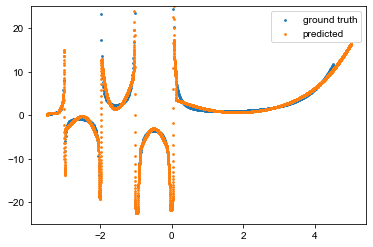

In [3]:
data_path = os.path.join(os.getcwd(), "data")
file = os.path.join(data_path, "gamma.in")
model = CFModel(15, k=3, lam=0, data_file=file, norm=1)
model.fit()
plt.scatter(model.X[:, 0], model.y, s=3, label='ground truth')
xx = np.linspace(-3.5, 5, 10000).reshape(10000, 1)
#plt.scatter(model.X[:, 0], model.predict(model.X), s=3)
plt.scatter(xx, model.predict(xx), s=3, label='predicted')
plt.legend()
plt.ylim(-25, 25)
plt.savefig('gamma15.eps', format='eps')
plt.savefig('gamma15.pdf', format='pdf')

<h4>Gamma with Depth=10</h4>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


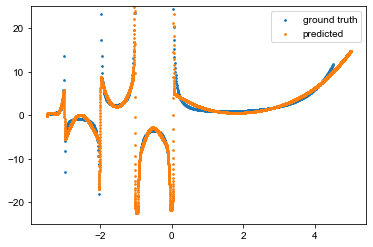

In [4]:
model = CFModel(10, k=3, lam=0, data_file=file, norm=1)
model.fit()
plt.scatter(model.X[:, 0], model.y, s=3, label='ground truth')
xx = np.linspace(-3.5, 5, 10000).reshape(10000, 1)
#plt.scatter(model.X[:, 0], model.predict(model.X), s=3)
plt.scatter(xx, model.predict(xx), s=3, label='predicted')
plt.legend()
plt.ylim(-25, 25)
plt.savefig('gamma10.eps', format='eps')
plt.savefig('gamma10.pdf', format='pdf')

<h4>Gamma with Depth=5</h4>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


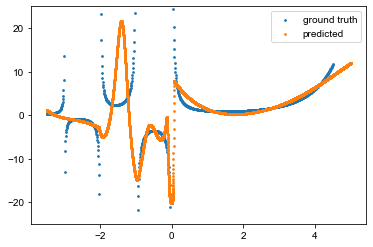

In [5]:
model = CFModel(5, k=3, lam=0, data_file=file, norm=1)
model.fit()
plt.scatter(model.X[:, 0], model.y, s=3, label='ground truth')
xx = np.linspace(-3.5, 5, 10000).reshape(10000, 1)
#plt.scatter(model.X[:, 0], model.predict(model.X), s=3)
plt.scatter(xx, model.predict(xx), s=3, label='predicted')
plt.legend()
plt.ylim(-25, 25)
plt.savefig('gamma5.eps', format='eps')
plt.savefig('gamma5.pdf', format='pdf')

<h4>Gamma with Depth=3</h4>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


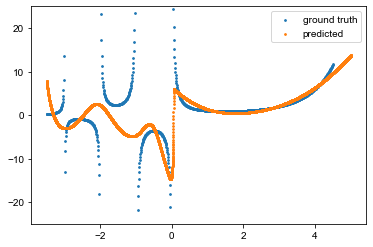

In [6]:
model = CFModel(3, k=3, lam=0, data_file=file, norm=1)
model.fit()
plt.scatter(model.X[:, 0], model.y, s=3, label='ground truth')
xx = np.linspace(-3.5, 5, 10000).reshape(10000, 1)
#plt.scatter(model.X[:, 0], model.predict(model.X), s=3)
plt.scatter(xx, model.predict(xx), s=3, label='predicted')
plt.legend()
plt.ylim(-25, 25)
plt.savefig('gamma3.eps', format='eps')
plt.savefig('gamma3.pdf', format='pdf')

<h3>Superconductivity</h3>
<h4>out-of-domain</h4>

In [7]:
file = os.path.join(data_path, "superconductivity_lowest-90.in")

model = CFModel(5, k=5, lam=0.5, data_file=file, norm=1000)
model.fit()

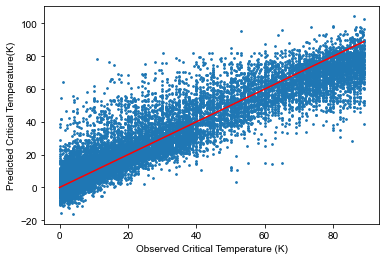

In [8]:
model.plot_obsexp("linearreg_low90")

In [9]:
trn_mse = model.mse()
trn_rmse = math.sqrt(trn_mse)
print("Training MSE={}\tRMSE={}".format(trn_mse, trn_rmse))

Training MSE=94.21213580906424	RMSE=9.706293618527322


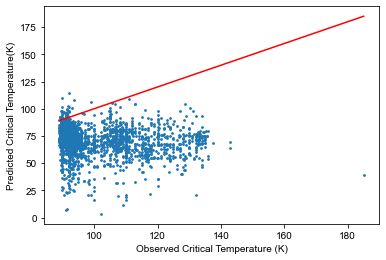

In [10]:
file = os.path.join(data_path, "superconductivity_highest-10.in")

model2 = CFModel(1, data_file=file, norm=1000)
model.X = model2.X
model.y = model2.y
model.plot_obsexp("linearreg_high10")

In [11]:
tst_mse = model.mse()
tst_rmse = math.sqrt(tst_mse)
print("Out-of-domain Test MSE={}\tRMSE={}".format(tst_mse, tst_rmse))

Out-of-domain Test MSE=1271.8931395869663	RMSE=35.663610860188655


<h3>Using XGBoost for out-of-domain prediction</h3>

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

file = os.path.join(data_path, "superconductivity_lowest-90.in")
model_trn = CFModel(1, data_file=file, norm=1000)
file = os.path.join(data_path, "superconductivity_highest-10.in")
model_tst = CFModel(1, data_file=file, norm=1000)

X_train = model_trn.X
y_train = model_trn.y
X_test = model_tst.X
y_test = model_tst.y


xg_reg = xgb.XGBRegressor(objective ='binary:logistic', n_estimators=374,
                          learning_rate=0.02, max_depth=16, min_child_weight=1, subsample=0.5)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.035203


In [13]:
def plot_obsexp(X, y, y_pred, norm=1):
    '''
    Creates an expected vs. observed plot for a fitted model.
    '''
    xx = np.linspace(y.min()*norm, y.max()*norm, 1000)
    plt.plot(xx, xx, c='r')
    plt.scatter(y*norm, y_pred*norm, s=3)
    plt.xlabel('Observed Critical Temperature (K)')
    plt.ylabel('Predicted Critical Temperature(K)')
    plt.savefig('obsexp.eps', format='eps')


<h4>XGBoost:: Observed-vs-Predicted for Out-of-domain</h4>

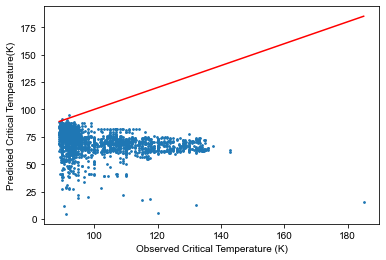

In [14]:
plot_obsexp(X_test, y_test, preds, norm=1000)

In [15]:
import pandas as pd
prev_obsrvd = {"predicted":preds*1000, "observed": y_test*1000}
df = pd.DataFrame(prev_obsrvd)
df.head()

,predicted,observed
0,83.666298,89.0
1,88.093330,89.0
2,74.410439,89.0
3,70.738007,89.0
4,85.206253,89.0


In [16]:
  
# top 10 predicted temperatures values
df.nlargest(10, ['predicted']) 

,predicted,observed
655,95.229454,92.00
156,91.335037,90.00
516,89.932816,91.30
85,89.311707,89.50
977,88.588478,93.50
582,88.216148,91.60
27,88.114861,89.10
45,88.114861,89.30
58,88.114861,89.40
484,88.114861,91.18


In [17]:
df[['observed']].mean()

observed    100.692347
dtype: float64

In [18]:
import statistics

statistics.mean(model_tst.y*1000)

100.69234713076199

In [19]:
df.nlargest(10, ['observed']) 

,predicted,observed
2125,15.255698,185.0
2123,61.154449,143.0
2124,62.626556,143.0
2122,66.323639,137.4
2120,64.976723,136.0
2121,65.106125,136.0
2119,63.132755,135.8
2118,63.845486,135.7
2117,63.845486,135.5
2116,62.707619,135.4
